In [1]:
import numpy as np 
import pandas as pd 

# Load train and test

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [4]:
_ = train.pop('id')

In [5]:
y = train.pop('Premium Amount')
X = train

In [6]:
data_processing_tr = X
data_processing_tr['y'] = y

# Data Cleaning

## Null Visualization

In [7]:
import missingno as msno
from matplotlib import pyplot as plt

In [8]:
X.columns[X.isnull().any()==False]

Index(['Gender', 'Education Level', 'Location', 'Policy Type',
       'Policy Start Date', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'y'],
      dtype='object')

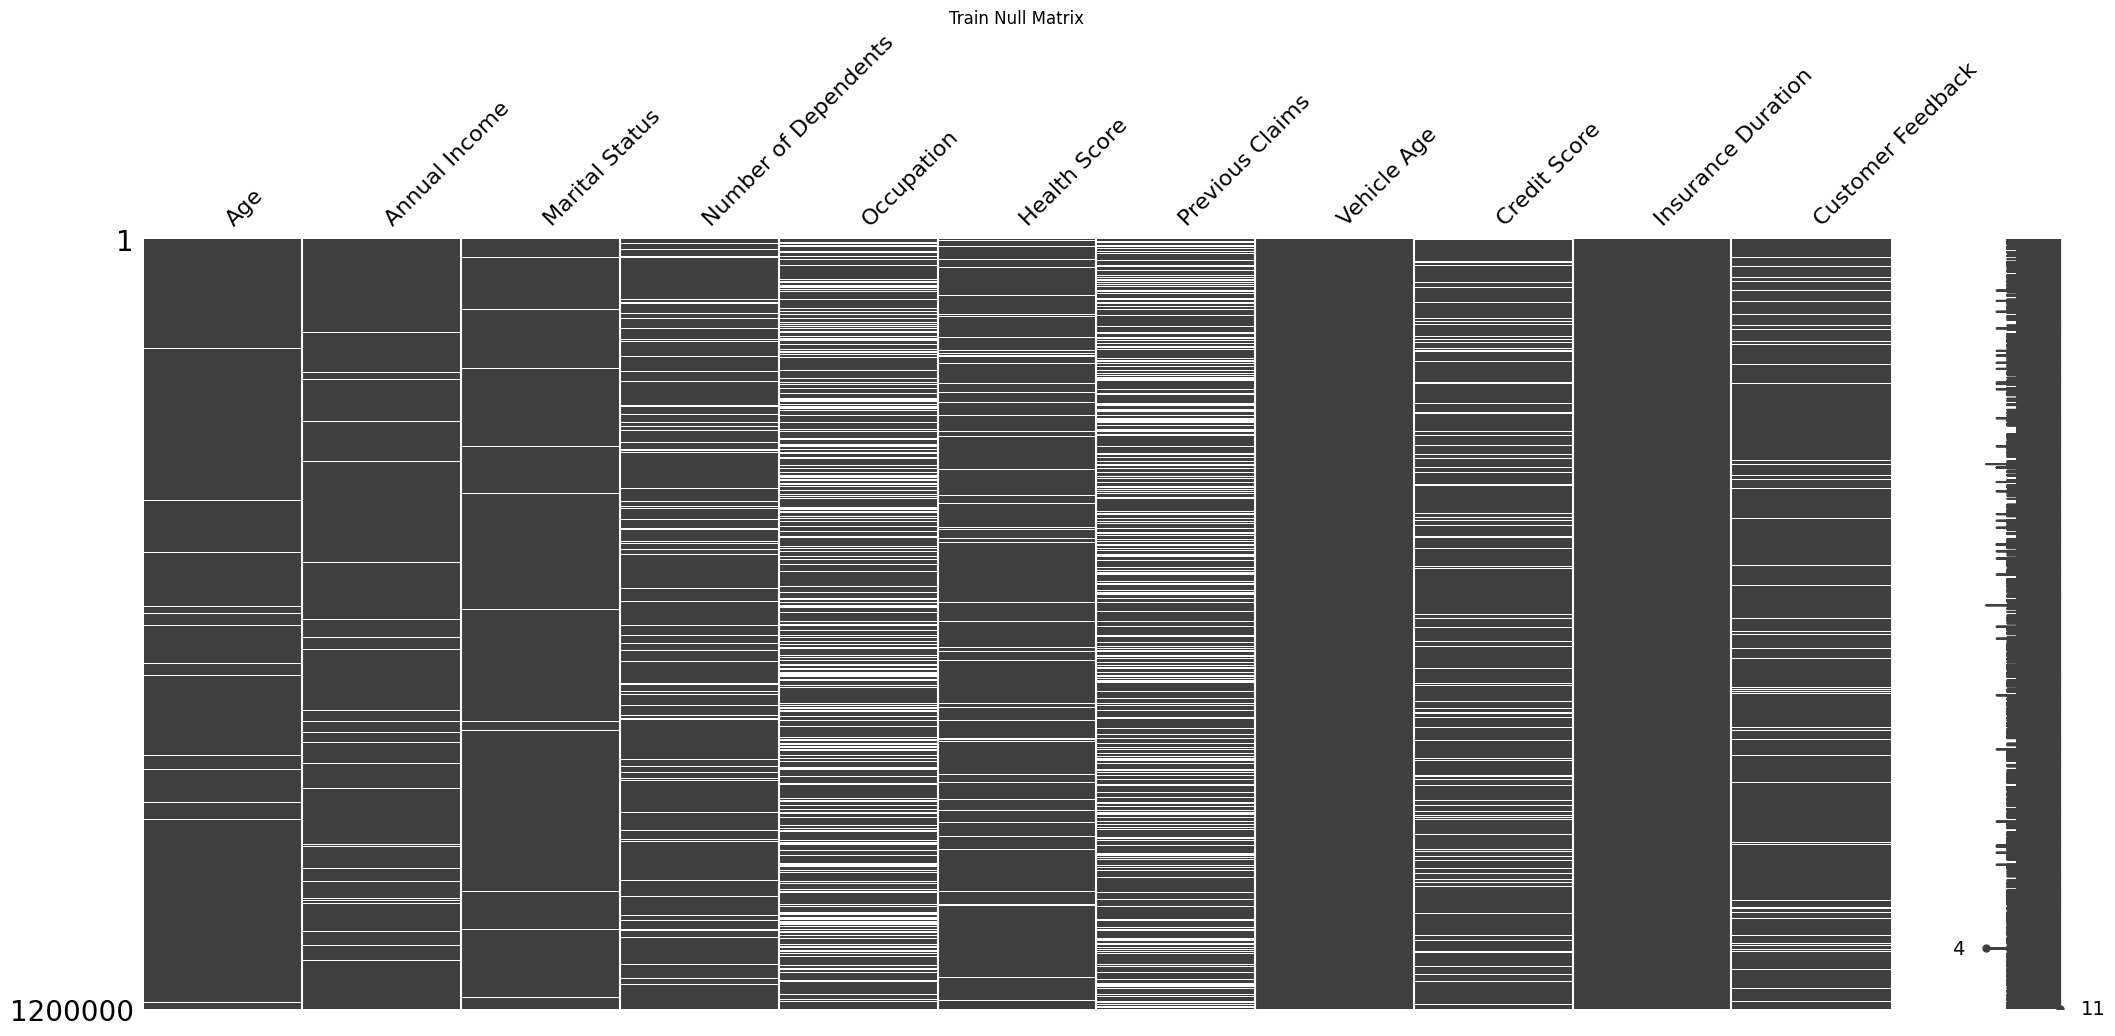

In [9]:
msno.matrix(X[X.columns[X.isnull().any()]])
_ = plt.title('Train Null Matrix')

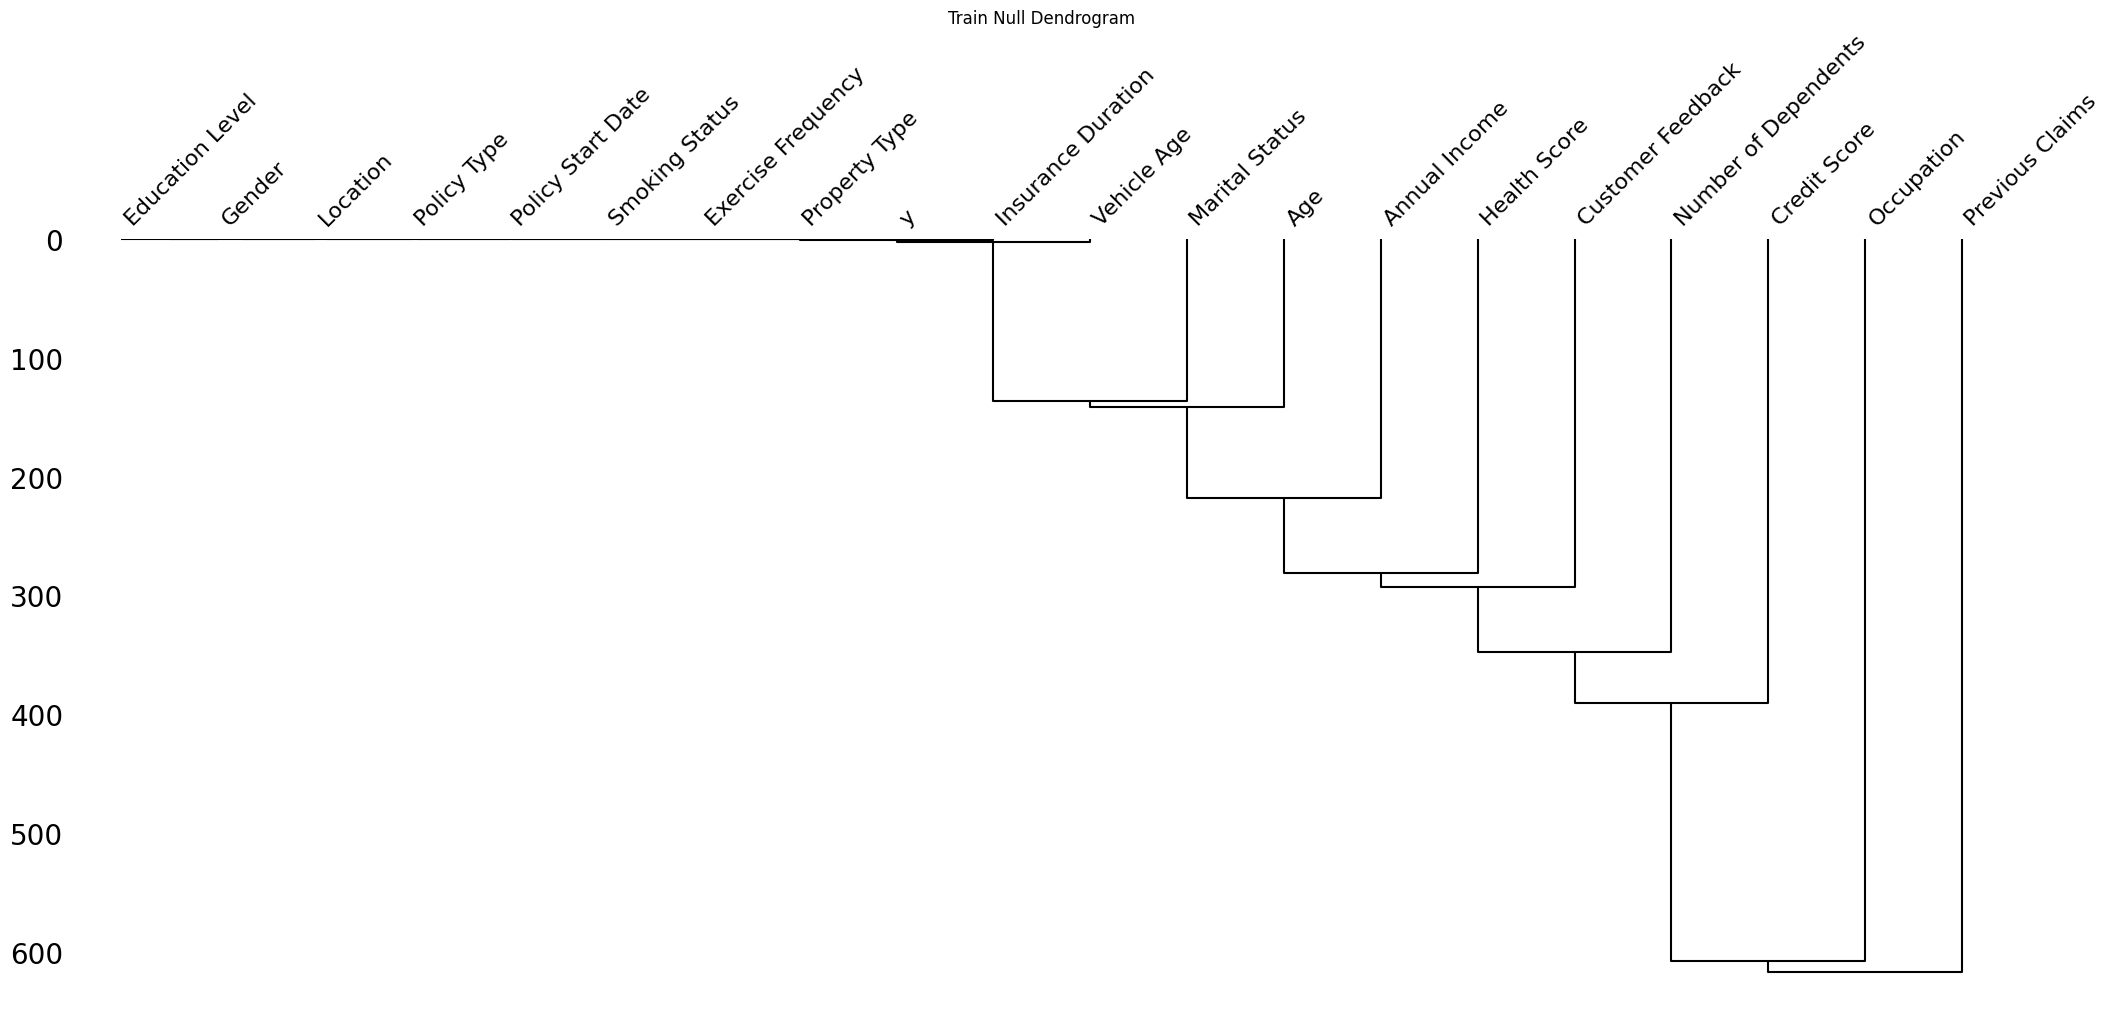

In [10]:
msno.dendrogram(X)
_ = plt.title('Train Null Dendrogram')

It seemse like Vehicle age and insurance duration are closely related. Shall look at these columns first. 

But before that, draw a dendrogram of test:

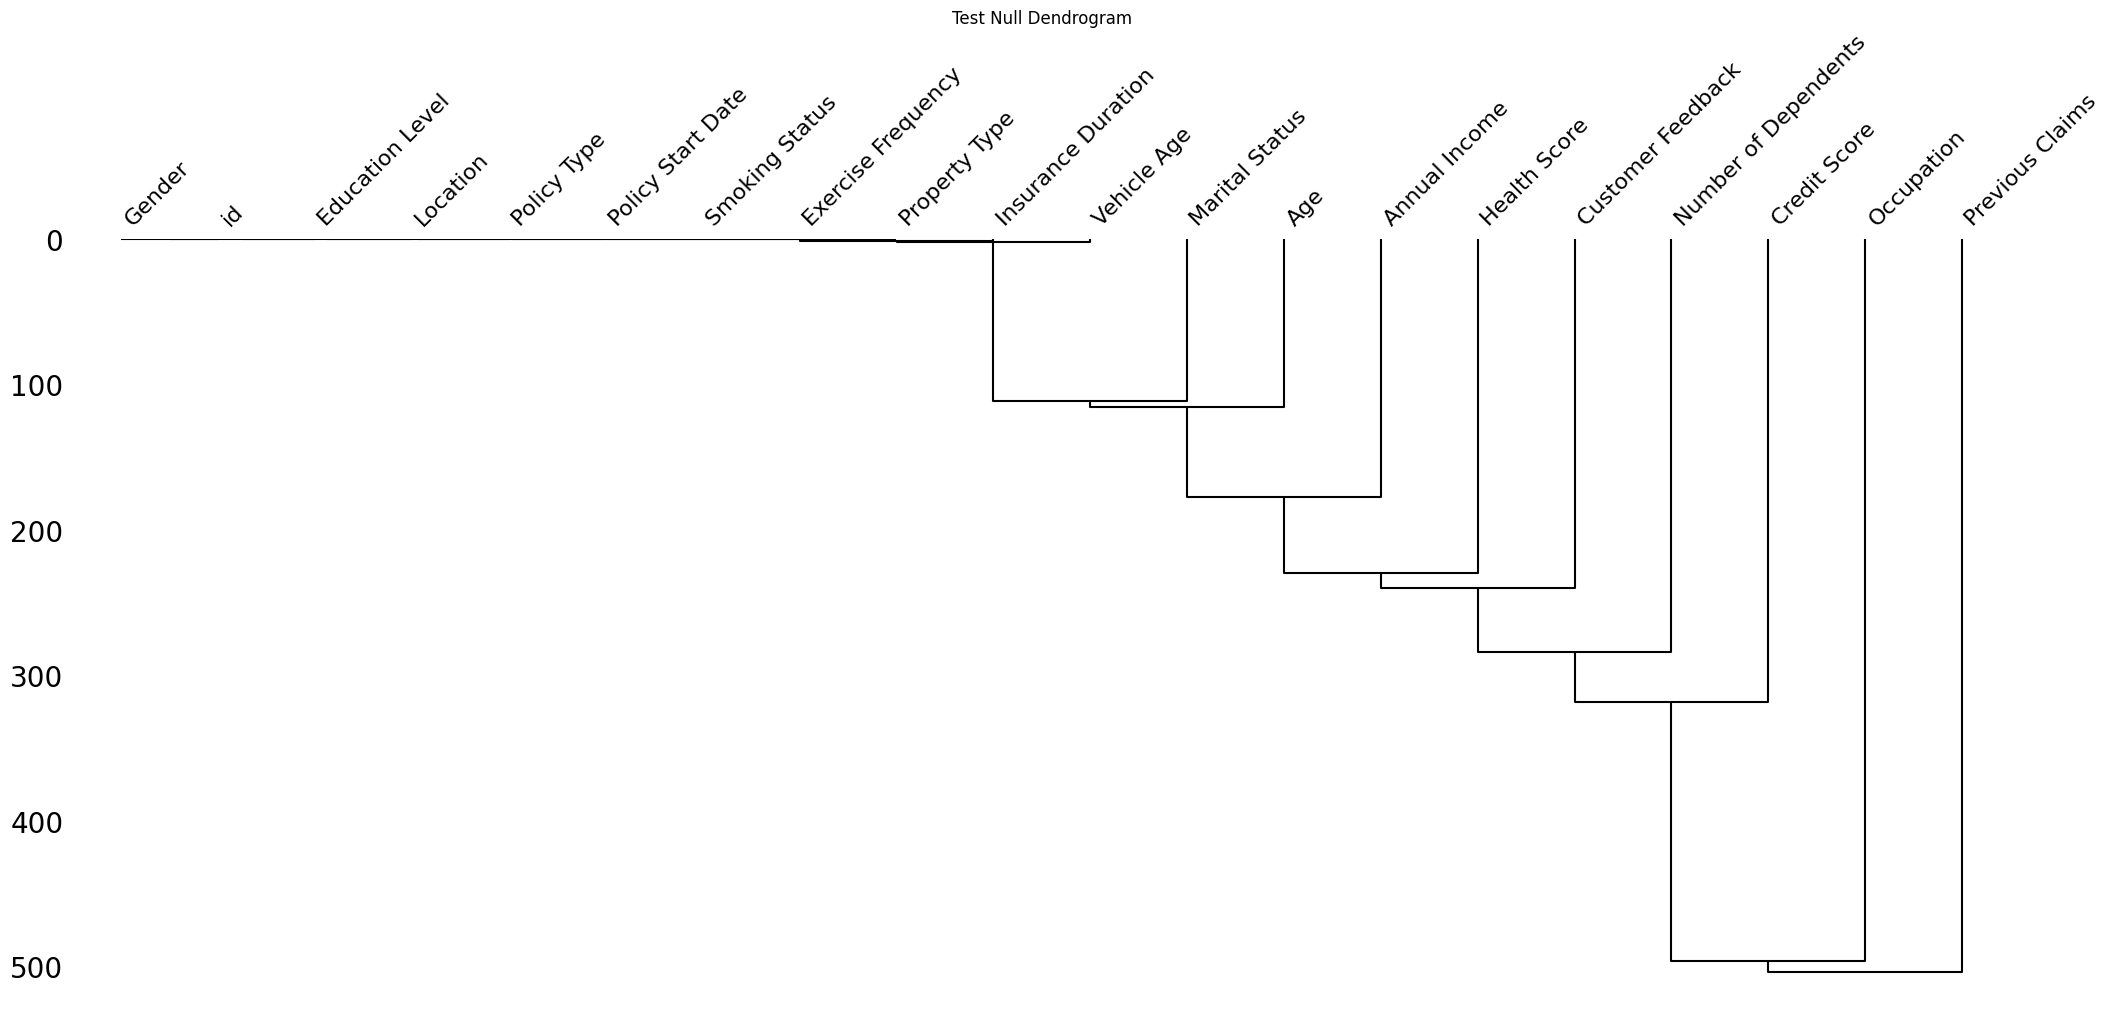

In [11]:
msno.dendrogram(test)
_ = plt.title('Test Null Dendrogram')

When I first try to clear nulls with Bayesian inference, the session ran out of memories. So I decided to look at other columns first

## Age

Does age group has strong relationship with target varaible?

In [12]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

compare_table = pairwise_tukeyhsd(endog=data_processing_tr['y'], groups=data_processing_tr['Age'], alpha=0.05)
compare_table = pd.DataFrame(data=compare_table.summary().data[1:], columns=compare_table.summary().data[0])
compare_table[compare_table['reject']==True]

,group1,group2,meandiff,p-adj,lower,upper,reject


Thus we conclude that age does not relate to target y directly

<Axes: xlabel='Age', ylabel='Density'>

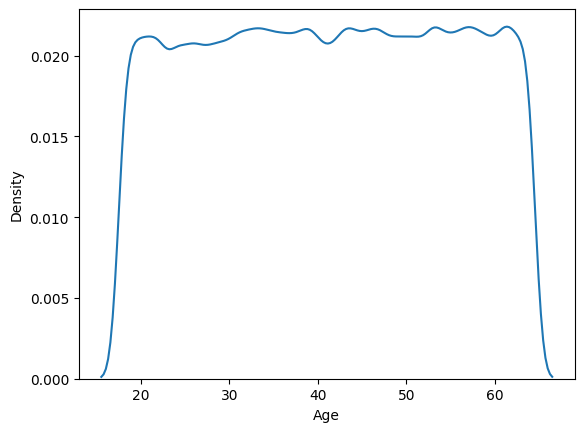

In [16]:
import seaborn as sns
sns.kdeplot(data_processing_tr['Age'])

In [17]:
import math
age_fill = math.floor(data_processing_tr['Age'].mean())
X.Age = X.Age.fillna(age_fill)

In [18]:
age_fill = math.floor(test.Age.mean())
test.Age = test.Age.fillna(age_fill)

## Annual Income

In [19]:
X['Annual Income'].isnull().sum()

44949

In [20]:
# examine independence between annual income and target
from scipy.stats import kendalltau

kendalltau(data_processing_tr['Annual Income'].dropna(), data_processing_tr.loc[~data_processing_tr['Annual Income'].isnull(), 'y'])

SignificanceResult(statistic=-0.04236252602993693, pvalue=0.0)

As the p value is 0 and $\tau = -0.04$, we conclude that there's a weak but significant relation here. Thus, we should choose our null value for this column wisely.

Several features that may relate to this:
1. Gender? (sadly, it's true in real world)
2. Marital status?
3. Location?
4. Education Level?
5. Occupation?

### Annual Income vs Marital Status

In [22]:
single_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Single', 'Annual Income'].dropna()
married_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Married', 'Annual Income'].dropna()
divorce_income = data_processing_tr.loc[data_processing_tr['Marital Status']=='Divorced', 'Annual Income'].dropna()
secret_income = data_processing_tr.loc[data_processing_tr['Marital Status'].isnull(), 'Annual Income'].dropna()
nonsecret_income = data_processing_tr.loc[~data_processing_tr['Marital Status'].isnull(), 'Annual Income'].dropna()

_, pval = ks_2samp(single_income, married_income)
print('p val from kstest between incomes of single and married: {}'.format(pval))
_, pval = ks_2samp(married_income, divorce_income)
print('p val from kstest between incomes of married and divorced: {}'.format(pval))
_, pval = ks_2samp(divorce_income, single_income)
print('p val from kstest between incomes of single and divorced: {}'.format(pval))
_, pval = mannwhitneyu(single_income, secret_income)
print('p val from kstest between incomes of single and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(married_income, secret_income)
print('p val from kstest between incomes of married and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(divorce_income, secret_income)
print('p val from kstest between incomes of divorced and null marital status: {}'.format(pval))
_, pval = mannwhitneyu(secret_income, nonsecret_income)
print('p val from kstest between incomes of unknown and known marital status: {}'.format(pval))

p val from kstest between incomes of single and married: 0.11549438146907232
p val from kstest between incomes of married and divorced: 0.08741758468542771
p val from kstest between incomes of single and divorced: 0.6527680407681833
p val from kstest between incomes of single and null marital status: 2.233037625591361e-80
p val from kstest between incomes of married and null marital status: 7.558214141079957e-81
p val from kstest between incomes of divorced and null marital status: 8.082451259971593e-81
p val from kstest between incomes of unknown and known marital status: 4.447111068826509e-83


In [23]:
from scipy.stats import cramervonmises_2samp
print(cramervonmises_2samp(secret_income, nonsecret_income))
print(cramervonmises_2samp(secret_income, single_income))
print(cramervonmises_2samp(secret_income, married_income))
print(cramervonmises_2samp(secret_income, divorce_income))

CramerVonMisesResult(statistic=78.60071858340234, pvalue=2.827819756134886e-08)
CramerVonMisesResult(statistic=75.6309274485593, pvalue=1.6193449692281092e-08)
CramerVonMisesResult(statistic=77.09346609784188, pvalue=2.1421009854805106e-08)
CramerVonMisesResult(statistic=75.67182054800105, pvalue=1.632295054676547e-08)


It looks like unknown marital status has a different distribution of income than other status. should have plot this out: 

In [24]:
secretship = data_processing_tr[data_processing_tr['Marital Status'].isnull()]
secretship.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,y
count,18529.000000,17573.000000,16657.000000,17623.000000,13222.000000,18529.000000,16253.000000,18529.000000,18529.000000
mean,41.093043,40273.786377,2.010926,25.939958,1.073514,9.616277,599.466191,5.002105,1217.871067
std,13.379156,38081.498250,1.424535,12.470474,1.024049,5.772856,148.384941,2.598314,904.286237
min,18.000000,17.000000,0.000000,2.068843,0.000000,0.000000,300.000000,1.000000,20.000000
25%,30.000000,6530.000000,1.000000,15.853765,0.000000,5.000000,480.000000,3.000000,571.000000
50%,41.000000,28574.000000,2.000000,25.084666,1.000000,10.000000,600.000000,5.000000,1001.000000
75%,53.000000,62735.000000,3.000000,35.505129,2.000000,15.000000,727.000000,7.000000,1659.000000
max,64.000000,149992.000000,4.000000,55.961187,7.000000,19.000000,849.000000,9.000000,4980.000000


In [25]:
nonsecretship = data_processing_tr[~data_processing_tr['Marital Status'].isnull()]

cramervonmises_2samp(secretship.y, nonsecretship.y)

CramerVonMisesResult(statistic=43.06235839321016, pvalue=5.582157958095024e-09)

<Axes: xlabel='y', ylabel='Density'>

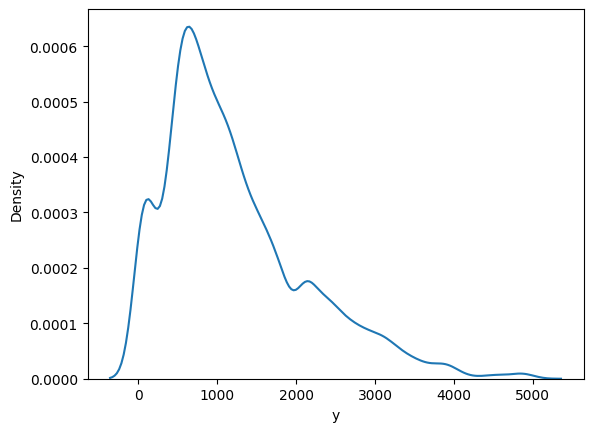

In [26]:
sns.kdeplot(secretship.y)

<Axes: xlabel='y', ylabel='Density'>

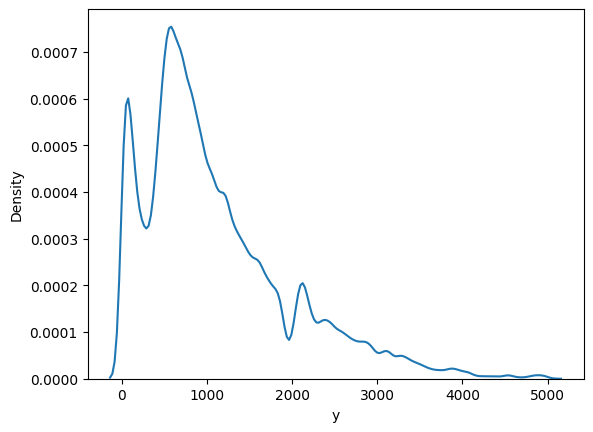

In [27]:
sns.kdeplot(nonsecretship.y)

next up: is there any difference in distributions of target variable between un-null marital status?

In [30]:
single_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Single', 'y']
married_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Married', 'y']
divorce_y = data_processing_tr.loc[data_processing_tr['Marital Status']=='Divorced', 'y']

_, pval1 = ks_2samp(single_y, married_y)
_, pval2 = ks_2samp(married_y, divorce_y)
_, pval3 = ks_2samp(divorce_y, single_y)
print(pval1)
print(pval2)
print(pval3)

0.650928436226483
0.5825681208624114
0.2064811835167979


So we can confirm that nulls here should be treated as a new category

In [42]:
X['Marital Status'].fillna('Other', inplace=True)
test['Marital Status'].fillna('Other', inplace=True)

<Axes: xlabel='Annual Income', ylabel='Density'>

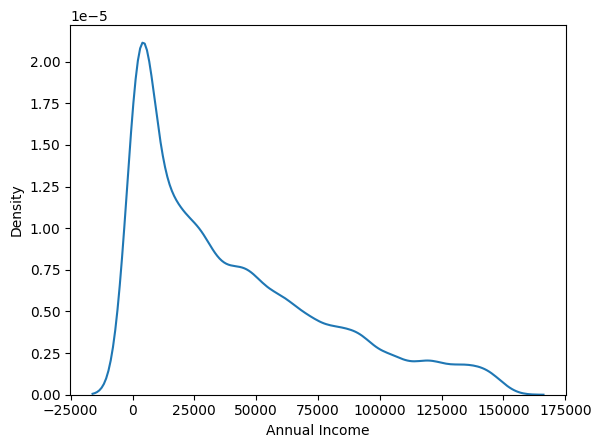

In [43]:
sns.kdeplot(X.loc[X['Marital Status']=='Other', 'Annual Income'])

<Axes: xlabel='Annual Income', ylabel='Density'>

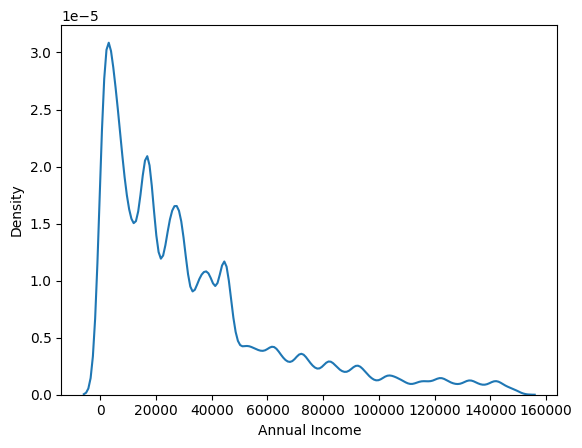

In [44]:
sns.kdeplot(nonsecretship['Annual Income'])

### Annual Income vs. Occupation

In [45]:
data_processing_tr['Occupation'].unique()

array(['Self-Employed', nan, 'Employed', 'Unemployed'], dtype=object)

In [81]:
self_income = data_processing_tr.loc[data_processing_tr['Occupation']=='Self-Employed', 'Annual Income'].dropna()
unknown_job_income = data_processing_tr.loc[data_processing_tr['Occupation'].isnull(), 'Annual Income'].dropna()
employ_income = data_processing_tr.loc[data_processing_tr['Occupation']=='Employed', 'Annual Income'].dropna()
unemploy_income = data_processing_tr.loc[data_processing_tr['Occupation']=='Unemployed', 'Annual Income'].dropna()

print(cramervonmises_2samp(unknown_job_income, self_income))
print(cramervonmises_2samp(employ_income, unknown_job_income))
print(cramervonmises_2samp(unemploy_income, unknown_job_income))
print(ks_2samp(unemploy_income, employ_income))
print(ks_2samp(self_income, unemploy_income))
print(ks_2samp(self_income, employ_income))

CramerVonMisesResult(statistic=2.607142884458881, pvalue=5.626949387549374e-07)
CramerVonMisesResult(statistic=1.748715526147862, pvalue=4.7074499283761284e-05)
CramerVonMisesResult(statistic=2.619873521136469, pvalue=5.271965044517657e-07)
KstestResult(statistic=0.002776054116014337, pvalue=0.2503700082663125, statistic_location=44260.0, statistic_sign=-1)
KstestResult(statistic=0.0017947025510595682, pvalue=0.7786026358442779, statistic_location=10173.0, statistic_sign=-1)
KstestResult(statistic=0.0034153020196490136, pvalue=0.08351477699355281, statistic_location=42115.0, statistic_sign=-1)


<Axes: ylabel='Density'>

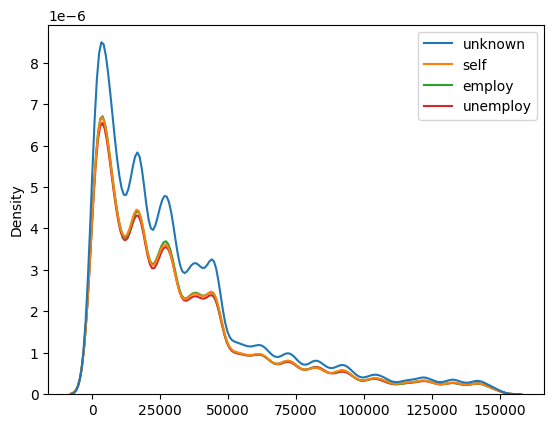

In [89]:
incomes2job = pd.DataFrame({'unknown': unknown_job_income, 'self': self_income, 'employ': employ_income, 'unemploy': unemploy_income})

sns.kdeplot(incomes2job)

In [87]:
self_y = data_processing_tr.loc[data_processing_tr['Occupation']=='Self-Employed', 'y'].dropna()
unknown_job_y = data_processing_tr.loc[data_processing_tr['Occupation'].isnull(), 'y'].dropna()
employ_y = data_processing_tr.loc[data_processing_tr['Occupation']=='Employed', 'y'].dropna()
unemploy_y = data_processing_tr.loc[data_processing_tr['Occupation']=='Unemployed', 'y'].dropna()

print(cramervonmises_2samp(unknown_job_y, self_y))
print(cramervonmises_2samp(employ_y, unknown_job_y))
print(cramervonmises_2samp(unemploy_y, unknown_job_y))
print(ks_2samp(unemploy_y, employ_y))
print(ks_2samp(self_y, unemploy_y))
print(ks_2samp(self_y, employ_y))

CramerVonMisesResult(statistic=2.7882692538987612, pvalue=2.2287360956774194e-07)
CramerVonMisesResult(statistic=5.199467765152804, pvalue=1.0328493615929801e-10)
CramerVonMisesResult(statistic=2.316429056081688, pvalue=2.5000264062269295e-06)
KstestResult(statistic=0.004079935047011013, pvalue=0.018989525703053945, statistic_location=285.0, statistic_sign=1)
KstestResult(statistic=0.002759796080574084, pvalue=0.2370265694318625, statistic_location=1517.0, statistic_sign=-1)
KstestResult(statistic=0.004937158754176718, pvalue=0.002027227444084327, statistic_location=578.0, statistic_sign=1)


<Axes: ylabel='Density'>

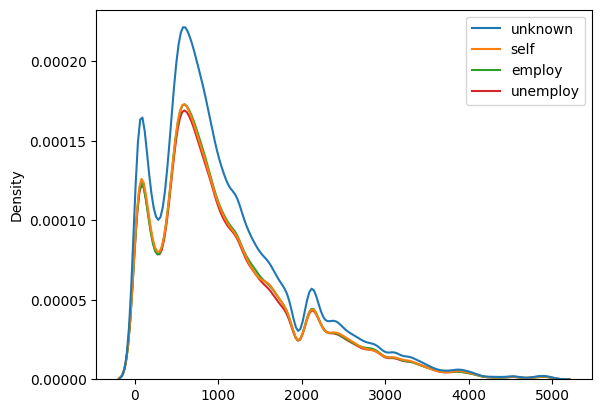

In [88]:
y2job = pd.DataFrame(
    {
        'unknown': unknown_job_y,
        'self': self_y,
        'employ': employ_y,
        'unemploy': unemploy_y
    }
)
sns.kdeplot(y2job)

We'll return to occupation later. 
The next thing here is, if education level has anythign to do with annual income?

### annual income vs. education level